<a href="https://colab.research.google.com/github/sanket0707/Pressure-to-Posture/blob/main/mit_cnn_tensorflow_Kingston_Changed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT pose estimation model using TensorFlow

<!--
This notebook teaches you how to train a pose classification model using MoveNet and TensorFlow Lite. The result is a new TensorFlow Lite model that accepts the output from the MoveNet model as its input, and outputs a pose classification, such as the name of a yoga pose.

The procedure in this notebook consists of 3 parts:
* Part 1: Preprocess the pose classification training data into a CSV file that specifies the landmarks (body keypoints) detected by the MoveNet model, along with the ground truth pose labels.
* Part 2: Build and train a pose classification model that takes the landmark coordinates from the CSV file as input, and outputs the predicted labels.
* Part 3: Convert the pose classification model to TFLite.

By default, this notebook uses an image dataset with labeled yoga poses, but we've also included a section in Part 1 where you can upload your own image dataset of poses. -->

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/pose_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Part 1: Load modules

In this section, you'll import the necessary libraries and define several functions to preprocess the MIT input data
Nothing observable happens here, but you can expand the hidden code cells to see the implementation for some of the functions we'll be calling later on.

**This script is written in python3.8 adn tensorflow2.9.0**

In [ ]:

!python --version

Python 3.10.12


In [ ]:

!pip install tensorflow==2.9.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ten

In [ ]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.9.0
Python 3.10.12


In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from tensorflow.python.keras.layers import Input, Dense

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.python.eager.context import jit_compile_rewrite_enabled
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Part 2: Load Data



In [ ]:
import os
import pickle

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Specify the dataset directory
dataset_dir = "/content/drive/MyDrive/PPIT/data/"

## Set up a TensorFlow Dataset



## Same

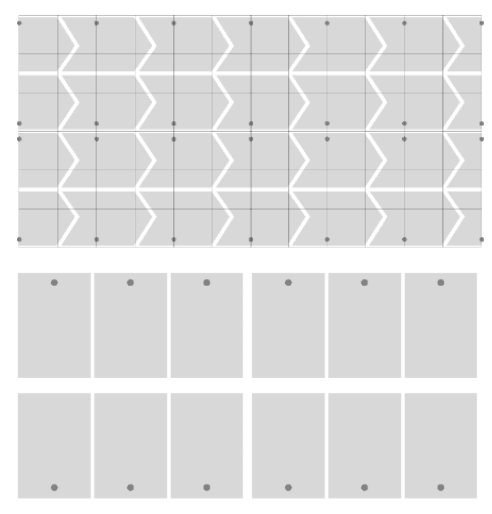

The pressure map structure is (13, 36)
Th sensor map structure should be (13, 24). 13 is in the horizontal sequence of  location/pressure/location/pressure... 24 should be just location.



Please double check in this block to create your input data as **model 1** uses 16 joints and **model 2** uses 14 joints (without left/right heel)

In [ ]:
import os

data_log = {
    'export_dir': {'/content/drive/MyDrive/PPIT/'},
    'joints': {'Left ankle': 12,
                'Left elbow': 4,
                'Left hip': 8,
                'Left knee': 10,
                'Left shoulder': 2,
                'Left toe': 14,
                'Left wrist': 6,
                'Right ankle': 11,
                'Right elbow': 3,
                'Right hip': 7,
                'Right knee': 9,
                'Right shoulder': 1,
                'Right toe': 13,
                'Right wrist': 5,

               }


}


In [ ]:
frame_no = 7
after_frame = 3
batch_size = 32
shuffle_buffer_size = 1000
num_epochs = 2

In [ ]:
file_path = "/content/drive/MyDrive/20230626_1_set_1_1.p"

In [ ]:
data = load_pickle_file(file_path)

In [ ]:
#data["location"]

In [ ]:
# Extract the input data and target data
reshaped_data = []
pressure = data["pressure"][1]
location = data["location"][1]

In [ ]:
def restack_electrode_data(pressure, location):
    frame_data = np.zeros((13,24))
    for i in range(frame_data.shape[0]):
      for j in range(frame_data.shape[1]):
        # i.   0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
        # loc  0,  , 1,  , 2,  , 3,  , 4,  ,  5,   ,  6
        # pres. , 0,  , 1,  , 2,  , 3,  , 4,   ,  5,


        # j.   0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ..., 22, 23
        # loc  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ..., 22, 23
        # pres.0, 0, 1, 1, 2, 2, 3, 3, 4, 4,  5,  5,  6,      11, 11
        source_i = i//2
        source_j = j
        source_data = location
        if i%2 != 0: # pressure
          source_data = pressure
          source_j = j // 2
        frame_data[i,j] = source_data[source_i, source_j]
    return frame_data

In [ ]:
restack_electrode_data = restack_electrode_data(pressure, location)

In [ ]:
restack_electrode_data.min()

-0.3

In [ ]:
restack_electrode_data.max()

5.425

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

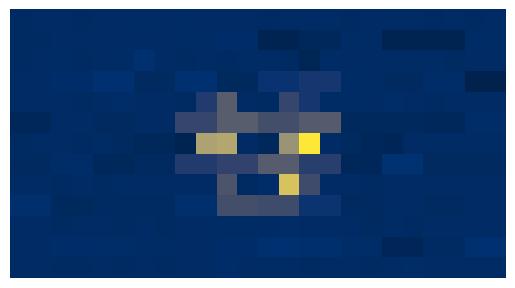

In [ ]:
normalized_array = (restack_electrode_data - restack_electrode_data.min()) / (restack_electrode_data.max() - restack_electrode_data.min()) * 255
image = normalized_array.astype(np.uint8)

#rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(image, cmap='cividis')
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
def data_generator(file_paths, batch_size, frame=frame_no, after_frame=after_frame):
    for file_path in file_paths:
        # Load the data from the pickle file

        data = load_pickle_file(file_path)

        # Extract the input data and target data
        reshaped_data = []
        for i in range(len(data["location"])):
          pressure = data["pressure"][i]
          location = data["location"][i]
          reshaped_data.append(restack_electrode_data(pressure, location))
        data["reshaped_electrode"] = np.array(reshaped_data)

        # Prepare input and target data
        input_data = []
        for i in range(len(data["reshaped_electrode"]) - frame + 1 - after_frame):
          input_data.append(data["reshaped_electrode"][i:i+frame+after_frame])
        input_data = np.array(input_data)

                # Ensure that the input data has the expected shape
        print("Input data shape before reshaping:", input_data.shape)


        #target_data = data["heatmap"]
        # generate target data with only a few keypoints
        target_data = np.stack((
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left toe']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right toe']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left ankle']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right ankle']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left knee']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right knee']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left hip']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right hip']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left shoulder']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right shoulder']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left elbow']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right elbow']-1,:],
                                data["keypoint"][frame-1:-after_frame, data_log['joints']['Left wrist']-1,:],
                                 data["keypoint"][frame-1:-after_frame, data_log['joints']['Right wrist']-1,:],
                                ),
                                axis=1)

        target_data = data["keypoint"][frame-1:-after_frame]
        target_data = target_data/32767

        # Ensure that the target data has the expected shape
        #print("Target data shape:", target_data.shape)

        # Yield the data in batches
        for i in range(0, (len(input_data) - frame - after_frame)//batch_size, batch_size):
          yield input_data[i*batch_size:(i+1)*batch_size], target_data[i*batch_size:(i+1)*batch_size]





In [ ]:
# Visualise the Frame data




In [ ]:
# Get a list of all files in the dataset directory
all_files = os.listdir(dataset_dir)

# Filter files to keep only those ending with ".p"
pickle_files = [file for file in all_files if file.endswith(".p")]

# Split the files into training and validation sets (adjust as needed)
split_ratio = 0.8
num_files = len(pickle_files)
num_train_files = int(split_ratio * num_files)

# Training and validation file paths
train_file_paths = [os.path.join(dataset_dir, file) for file in pickle_files[:num_train_files]]
val_file_paths = [os.path.join(dataset_dir, file) for file in pickle_files[num_train_files:]]

# Print the training file paths
for path in train_file_paths:
  print(path)

# Create a TensorFlow dataset for the training set
train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(train_file_paths, batch_size), output_types=(tf.float32, tf.float32))
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size).repeat(num_epochs)

# Create a TensorFlow dataset for the validation set
val_dataset = tf.data.Dataset.from_generator(lambda: data_generator(val_file_paths, batch_size), output_types=(tf.float32, tf.float32))
val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer_size).repeat(num_epochs)

# Create a TensorFlow dataset for prediction and visualization on the validation set
visual_dataset_val = tf.data.Dataset.from_generator(lambda: data_generator(val_file_paths, batch_size), output_types=(tf.float32, tf.float32))

# Create a TensorFlow dataset for prediction and visualization on the training set (excluding the first file)
visual_dataset_train = tf.data.Dataset.from_generator(lambda: data_generator(train_file_paths[1:], batch_size), output_types=(tf.float32, tf.float32))


/content/drive/MyDrive/PPIT/data/20230626_1_set_2_2.p
/content/drive/MyDrive/PPIT/data/20230626_7_set_1_2.p
/content/drive/MyDrive/PPIT/data/20230626_6_set_2_1.p
/content/drive/MyDrive/PPIT/data/20230626_2_set_1_4.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_2_1.p
/content/drive/MyDrive/PPIT/data/20230626_6_set_2_2.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_2_5.p
/content/drive/MyDrive/PPIT/data/20230626_2_set_1_6.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_1_5.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_2_3.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_2_4.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_1_3.p
/content/drive/MyDrive/PPIT/data/20230626_6_set_1_2.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_1_2.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_1_4.p
/content/drive/MyDrive/PPIT/data/20230626_3_set_1_2.p
/content/drive/MyDrive/PPIT/data/20230626_1_set_1_1.p
/content/drive/MyDrive/PPIT/data/20230626_2_set_1_5.p


In [ ]:
# # with open(os.path.join(data_log['export_dir'], "20230626_1_set_1_1.p"), 'rb') as file:
# #     loaded_data = pickle.load(file)
# # print(loaded_data)

# # Access the 'pressure' array
# pressure_data = loaded_data['pressure']
# pressure_data

In [ ]:
# # Assuming train_dataset and val_dataset are TensorFlow datasets
# # Example for TensorFlow dataset
# # Note: This assumes that the dataset contains batches, so we take the shape of one batch.
# input_shape_train = next(iter(train_dataset))[0].shape
# input_shape_val = next(iter(val_dataset))[0].shape

# print("Shape of input data in train_dataset:", input_shape_train)
# print("Shape of input data in val_dataset:", input_shape_val)


Input data shape before reshaping: (529, 10, 13, 24)
Target data shape: (529, 14, 3)
Input data shape before reshaping: (1307, 10, 13, 24)
Target data shape: (1307, 14, 3)
Input data shape before reshaping: (1231, 10, 13, 24)
Target data shape: (1231, 14, 3)
Input data shape before reshaping: (1518, 10, 13, 24)
Target data shape: (1518, 14, 3)
Input data shape before reshaping: (1029, 10, 13, 24)
Target data shape: (1029, 14, 3)
Input data shape before reshaping: (1605, 10, 13, 24)
Target data shape: (1605, 14, 3)
Input data shape before reshaping: (873, 10, 13, 24)
Target data shape: (873, 14, 3)
Input data shape before reshaping: (1618, 10, 13, 24)
Target data shape: (1618, 14, 3)
Input data shape before reshaping: (1595, 10, 13, 24)
Target data shape: (1595, 14, 3)
Input data shape before reshaping: (1904, 10, 13, 24)
Target data shape: (1904, 14, 3)
Input data shape before reshaping: (2000, 10, 13, 24)
Target data shape: (2000, 14, 3)
Input data shape before reshaping: (2068, 10, 1

# Part3: AUTOENCODER MODEL

## construct model architecture (generate keypoint)

###  full body coordinates (Model 2)
This model use Conv3D and data collected in 2023. It contains 14 joints (keypoints)


This model give validation loss in the range of 0.015.


In [ ]:


def construct_model(keep_layer=1):
  dropout=0.3
  decoder_layer = [1024,512,256,128,64]
  InputLayer = tf.keras.layers.Input(batch_size=32, shape=(frame_no+after_frame, 13, 24))
  # layer_index = tf.keras.layers.Input(shape=(10, 10, 1, 9))
  print("check the tensor type in InputLayer", InputLayer.get_shape())

  ######################################################
  #
  #   ENCODER
  #
  #######################################################

  x = InputLayer
  print(x.shape)

  x = tf.expand_dims(x, axis=-1)
  print(x.shape)

  x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                            # kernel_initializer=tf.keras.initializers.Ones(),
                            # bias_initializer=tf.keras.initializers.Ones()
                            )(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)

  # 2nd layers from 32 to 64
  x = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)

  # 3rd layers from 64 to 128
  x = tf.keras.layers.Conv2D(128, (4,2), strides=(2,2))(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)

  # 3rd layers from 64 to 128
  x = x[:,:,0,:,:]
  print(x.shape)
  x = tf.keras.layers.Conv2D(128, (4,1), strides=(3,1))(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(5376)(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)
  x = tf.keras.layers.Reshape((14,3,128))(x)
  print(x.shape)


  # # ######################################################
  # #
  # # ##   DECODER
  # # #
  # # #######################################################

  x = tf.keras.layers.Conv2D(32, (2,2), strides=1, padding='same')(x)
  x = tf.keras.activations.tanh(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  print(x.shape)


  # 6th layer from 64 to 2, 2 is the number of joints in keypoints

  x = tf.keras.layers.Conv2D(1, (2,2), strides=1, padding='same')(x)
  x = tf.keras.activations.tanh(x)
  print(x.shape)
  OutputLayer = x

  return InputLayer, OutputLayer

construct_model()


check the tensor type in InputLayer (32, 10, 13, 24)
(32, 10, 13, 24)
(32, 10, 13, 24, 1)
(32, 10, 7, 12, 32)
(32, 10, 4, 6, 64)
(32, 10, 1, 3, 128)
(32, 10, 3, 128)
(32, 3, 3, 128)
(32, 5376)
(32, 14, 3, 128)
(32, 14, 3, 32)
(32, 14, 3, 1)


(<KerasTensor: shape=(32, 10, 13, 24) dtype=float32 (created by layer 'input_12')>,
 <KerasTensor: shape=(32, 14, 3, 1) dtype=float32 (created by layer 'tf.math.tanh_83')>)

## Define loss

In [ ]:
class heatmap_to_keypoint():
    """
    It creates  a keypoint (frame, joints, xyz) from a heatmap (frame, joints, 3Dheatmap_resolution)
    Output keypoint should be in the range of (-32767,32767) as the input in keypoint_to_heatmap
    The 3Dheatmap_resolution is (20, 20, 18) in the MIT model.
    """

    def __init__(self, axis_range=32767):
        self.axis_range = axis_range

    def __call__(self, heatmap, heatmap_shape=[20,20,18]):
        """
        heatmap is numpy array, it has a shape of (batch_size, joints, 3Dheatmap_resolution_in_xyz_axis)
        return data of size (frame, joints, xyz), data range is [0,1] before reverse_normalise,
        [-32767,32767) after reverse_normalise
        """
        y, x, z = [tf.linspace(0., 1., int(heatmap_shape[i]))
              for i in range(3)]
        self.pos_xyz = tf.meshgrid(x,y,z) # shape is [3, 20, 20, 18] here
        # heatmap = tf.reshape(heatmap, (*heatmap.shape[:-3], *heatmap_shape)) might not need it

        # heatmap shape is (batch_size, joints, 3Dheatmap_resolution_in_xyz_axis)

        eps = 1e-12
        expected_xyz = [
            tf.reduce_sum(tf.multiply([[self.pos_xyz[i]]], heatmap), axis=[-3,-2,-1])
            / (tf.reduce_sum(heatmap, axis=[-3,-2,-1]) + eps)
            for i in range(3)
        ] #The output shape is (3, batch_size, 16) where 16 is the joint number

        expected_xyz = tf.transpose(expected_xyz, perm=[1, 2, 0])

        expected_xyz = tf.convert_to_tensor(expected_xyz) # shape of (batch_size, 16, 3)
        xyz_float = self.reverse_normalise(expected_xyz) # shape of (batch_size, 16, 3)
        return xyz_float

    def reverse_normalise(self, data):
        """
        data has the shape of (batch_size, joints, xyz)
        """
        return data * self.axis_range * 2 - self.axis_range

In [ ]:

heatmap2keypoint = heatmap_to_keypoint()
# keypoint2heatmap = keypoint_to_heatmap()
# link = tf.convert_to_tensor(data_log['link_limit'][0])
# limit = tf.convert_to_tensor(data_log['link_limit'][1])


def heatmap_loss(heatmap_GT, heatmap_pred, epsilon=1e-12):

    # heatmap_out = tf.where(heatmap_pred < epsilon, 0.0, heatmap_pred)
    loss = tf.reduce_mean(tf.square(heatmap_pred - heatmap_GT) * (heatmap_GT + 0.5) * 2) * 1000
    # loss = tf.reduce_mean(heatmap_pred, axis=(0,1,2))
    # loss = tf.reduce_mean(heatmap_pred)
    return loss*100

def keypoint_loss(keypoint_GT, keypoint_pred):
    keypoint_pred = tf.squeeze(keypoint_pred)
    keypoint_pred = tf.squeeze(keypoint_pred)
    loss = tf.reduce_mean(tf.square(keypoint_pred - keypoint_GT))
    return loss

reindex = {
    14: 0,
    13: 1,
    16: 2,
    15: 3,
    12: 4,
    11: 5
}

def link_loss(keypoint_pred):
    # link limit has the shape of (number of links, 2, 2), Axis 1 is linked joints. Axis 2 is the lower and upper limit of the link
    # The keypoint data has a shape of (time_frame, joint, xyz), time_frame could be 1
    #keypoint_pred has a shape of (batch_size, 16, 3)
    loss = []

    keypoint_pred = tf.squeeze(keypoint_pred)
    keypoint_pred = tf.squeeze(keypoint_pred)


    for link_limit in data_log['link_limit']:
        link, limit = link_limit
        try: # This to to avoid excess links
          distance = tf.norm(keypoint_pred[:, reindex[link[1]], :] - keypoint_pred[:, reindex[link[0]], :],
                              ord='euclidean', axis=0)
        except:
          continue
        # Calcuate how much is the predicted link away from the range. 3000 here is to calibrate
        #the maximum loss to be less than 10. This is to keep consistence with the MIT model

        distance = distance * 32767
        dist_diff = tf.where((distance > limit[0]) & (distance < limit[1]), 0.0, distance)
        loss_per_link = tf.reduce_mean(dist_diff)
        loss.append(loss_per_link)
    return tf.reduce_mean(loss)

def custom_loss(keypoint_GT, keypoint_pred):

    # keypoint_pred = tf.map_fn(lambda x:
    #                           tf.py_function(heatmap2keypoint, [x], tf.float32),
    #                           heatmap_pred)

    # keypoint_pred = heatmap2keypoint(heatmap_pred, heatmap_shape=heatmap_shape) # shape of (batch_size, joint, 3)
    loss1 = keypoint_loss(keypoint_GT, keypoint_pred)
    # print('loss1', heatmap_pred)
    # loss2 = link_loss(keypoint_pred)/3000/2
    # print('loss2', loss2.value)

    return loss1






## compile model

In [ ]:

from keras.callbacks import LambdaCallback
import datetime

def callbacks():

   # Define model and submodel directory names
  model_dirname = 'model'  # Replace with your model name
  submodel_dirname = 'submodel'  # Replace with your submodel name

  # Define the CSVLogger callback to save logs to a CSV file

  log_dir = os.path.join(list(data_log['export_dir'])[0], model_dirname, submodel_dirname, 'training_logs.csv')
  csv_logger = keras.callbacks.CSVLogger(log_dir)

  # Create a TensorBoard callback and specify the log directory
  log_dir = os.path.join(list(data_log['export_dir'])[0], model_dirname, submodel_dirname, 'logs', 'fit')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  # Define a custom callback to print the value of a tensor
  # class PrintTensorCallback(tf.keras.callbacks.Callback):
  #     def on_train_batch_end(self, batch, logs=None):
  #         # print('Value of loss:',  self.model.layers[24].output)
  #         return
  ################## Add weight callback
  checkpoint_dir = os.path.join(list(data_log['export_dir'])[0], model_dirname, submodel_dirname, 'checkpoint{epoch:02d}-{val_loss:.2f}')
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  # Define a custom callback to stop the epoch early
  early_stopping = tf.keras.callbacks.EarlyStopping(
                                                  monitor='val_loss',
                                                  min_delta=0,
                                                  patience=3,
                                                  verbose=0,
                                                  mode='auto',
                                                  baseline=None,
                                                  restore_best_weights=False,
                                                  # start_from_epoch=0
                                              )


  # Train the model with the callback
  # heatmap_GT_tensor = tf.convert_to_tensor(heatmap_GT)
  # , callbacks=[csv_logger]
  return early_stopping, csv_logger,tensorboard_callback

### Fit and save

In [ ]:
%reload_ext tensorboard

In [ ]:
# Load tensorflow board to visualise
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
# Define model and submodel directory names
model_dirname = 'model'
submodel_dirname = 'submodel'

In [ ]:
##### To start a new model
InputLayer, OutputLayer = construct_model()
model = keras.Model(InputLayer, OutputLayer)
model.summary()

check the tensor type in InputLayer (32, 10, 13, 24)
(32, 10, 13, 24)
(32, 10, 13, 24, 1)
(32, 10, 7, 12, 32)
(32, 10, 4, 6, 64)
(32, 10, 1, 3, 128)
(32, 10, 3, 128)
(32, 3, 3, 128)
(32, 5376)
(32, 14, 3, 128)
(32, 14, 3, 32)
(32, 14, 3, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(32, 10, 13, 24)]        0         
                                                                 
 tf.expand_dims_12 (TFOpLamb  (32, 10, 13, 24, 1)      0         
 da)                                                             
                                                                 
 conv2d_72 (Conv2D)          (32, 10, 7, 12, 32)       320       
                                                                 
 batch_normalization_60 (Bat  (32, 10, 7, 12, 32)      128       
 chNormalization)                                                
                

Epoch 1/2
Input data shape before reshaping: (529, 10, 13, 24)
Target data shape: (529, 14, 3)
Input data shape before reshaping: (1307, 10, 13, 24)
Target data shape: (1307, 14, 3)
Input data shape before reshaping: (1231, 10, 13, 24)
Target data shape: (1231, 14, 3)
Input data shape before reshaping: (1518, 10, 13, 24)
Target data shape: (1518, 14, 3)
Input data shape before reshaping: (1029, 10, 13, 24)
Target data shape: (1029, 14, 3)
Input data shape before reshaping: (1605, 10, 13, 24)
Target data shape: (1605, 14, 3)
Input data shape before reshaping: (873, 10, 13, 24)
Target data shape: (873, 14, 3)
Input data shape before reshaping: (1618, 10, 13, 24)
Target data shape: (1618, 14, 3)
Input data shape before reshaping: (1595, 10, 13, 24)
Target data shape: (1595, 14, 3)
Input data shape before reshaping: (1904, 10, 13, 24)
Target data shape: (1904, 14, 3)
Input data shape before reshaping: (2000, 10, 13, 24)
Target data shape: (2000, 14, 3)
Input data shape before reshaping: (2

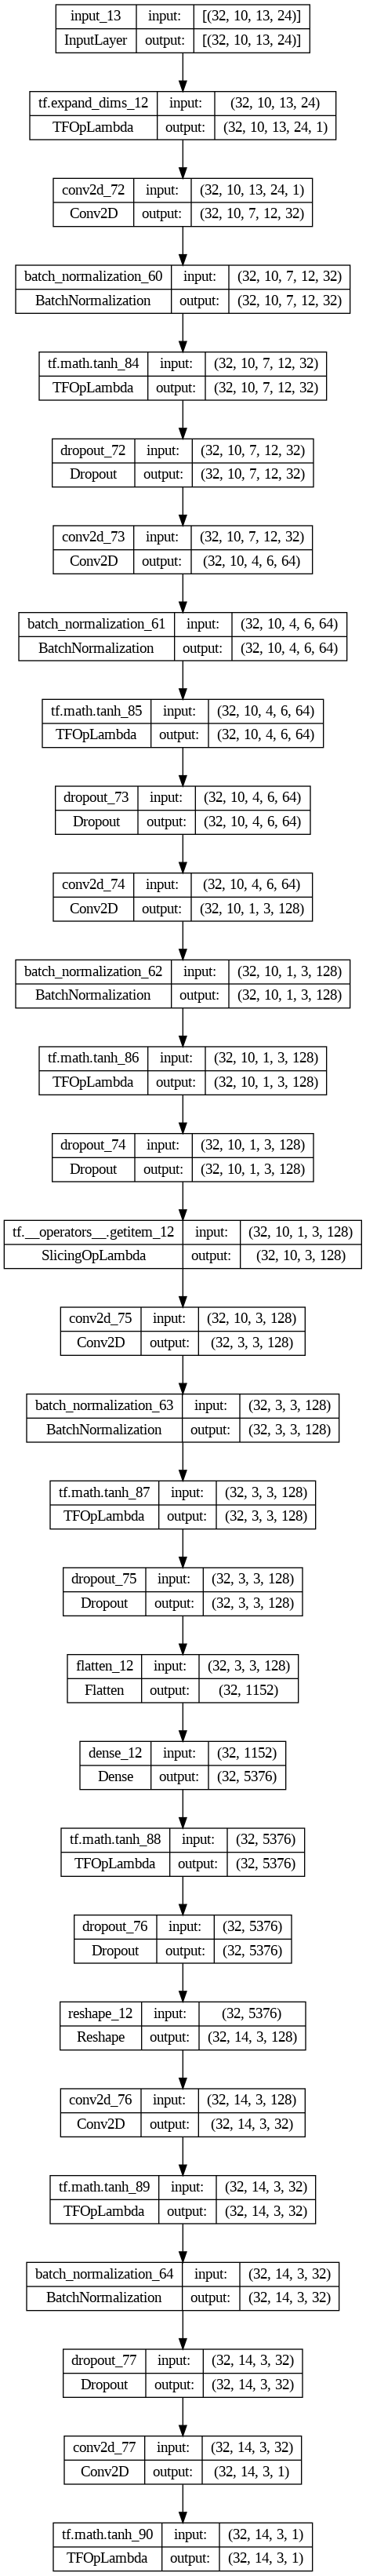

In [ ]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

# Compile your model with your custom loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,
                                                 decay=0.003,
                                                 clipvalue=1,
                                                 ),
              loss=custom_loss)
######
##### To start from an existing model
# model_path = os.path.join(data_log['export_dir'], model_dirname, 'checkpoint02-6.52')
# model = tf.keras.models.load_model(model_path, custom_objects={"keypoint_loss": keypoint_loss,
#                                                                "optimizer":tf.keras.optimizers.Adam(learning_rate=0.0005,
#                                                  decay=0.003)})
#####
# debug
tf.debugging.experimental.enable_dump_debug_info(os.path.join(list(data_log['export_dir'])[0], model_dirname, submodel_dirname, "/tmp/tfdbg"))
#######

model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset,
          callbacks=[*callbacks()],
          batch_size=batch_size, verbose=1)

# Disable the debugger
tf.debugging.experimental.disable_dump_debug_info()

model_path = os.path.join(list(data_log['export_dir'])[0], model_dirname, submodel_dirname, 'tensorflow')
try:
  os.mkdir(model_path)
except:
  None
model.save(model_path)
plot_model(model, to_file=model_path+'.png', show_shapes=True)